# Think Bayes: Chapter 5

This notebook presents code and exercises from Think Bayes, second edition.

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT

In [1]:
from __future__ import print_function, division

%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from IPython.display import display
from sympy import symbols
import matplotlib.pyplot as plt
import mythinkbayes as mtb
import numpy as np
import pdb
import scipy.stats

'Done'

'Done'

## Odds

The following function converts from probabilities to odds.

In [2]:
def Odds(p):
    return p / (1-p)

And this function converts from odds to probabilities.

In [3]:
def Probability(o):
    return o / (o+1)

If 20% of bettors think my horse will win, that corresponds to odds of 1:4, or 0.25.

In [4]:
p = 0.2
Odds(p)

0.25

If the odds against my horse are 1:5, that corresponds to a probability of 1/6.

In [5]:
o = 1/5
Probability(o)

0.16666666666666669

We can use the odds form of Bayes's theorem to solve the cookie problem:

In [6]:
prior_odds = 1
likelihood_ratio = 0.75 / 0.5
post_odds = prior_odds * likelihood_ratio
post_odds

1.5

And then we can compute the posterior probability, if desired.

In [7]:
post_prob = Probability(post_odds)
post_prob

0.6

If we draw another cookie and it's chocolate, we can do another update:

In [8]:
likelihood_ratio = 0.25 / 0.5
post_odds *= likelihood_ratio
post_odds

0.75

And convert back to probability.

In [9]:
post_prob = Probability(post_odds)
post_prob

0.42857142857142855

## Oliver's blood

The likelihood ratio is also useful for talking about the strength of evidence without getting bogged down talking about priors.

As an example, we'll solve this problem from MacKay's *Information Theory, Inference, and Learning Algorithms*:

> Two people have left traces of their own blood at the scene of a crime.  A suspect, Oliver, is tested and found to have type 'O' blood.  The blood groups of the two traces are found to be of type 'O' (a common type in the local population, having frequency 60) and of type 'AB' (a rare type, with frequency 1). Do these data [the traces found at the scene] give evidence in favor of the proposition that Oliver was one of the people [who left blood at the scene]?

If Oliver is
one of the people who left blood at the crime scene, then he
accounts for the 'O' sample, so the probability of the data
is just the probability that a random member of the population
has type 'AB' blood, which is 1%.

$P(\text{D | Oliver accounts for type O }) = P(\text{( Oliver, someone with AB) | Oliver accounts for type O }) = P(\text{ someone with AB }) = 0.01$

If Oliver did not leave blood at the scene, then we have two
samples to account for.  If we choose two random people from
the population, what is the chance of finding one with type 'O'
and one with type 'AB'?  Well, there are two ways it might happen:
the first person we choose might have type 'O' and the second
'AB', or the other way around.  So the total probability is
$2 (0.6) (0.01) = 1.2$%.

$P(\text{D | Not Oliver }) = P(\text{ (O, AB) | Not Oliver }) + P(\text{ (AB, O) | Not Oliver }) = 2 \times 0.5 \times0.01$

So the likelihood ratio is:

In [10]:
like1 = 0.01
like2 = 2 * 0.6 * 0.01

likelihood_ratio = like1 / like2
likelihood_ratio

0.8333333333333334

Since the ratio is less than 1, it is evidence *against* the hypothesis that Oliver left blood at the scence.

But it is weak evidence.  For example, if the prior odds were 1 (that is, 50% probability), the posterior odds would be 0.83, which corresponds to a probability of:

In [11]:
post_odds = 1 * like1 / like2
Probability(post_odds)

0.45454545454545453

So this evidence doesn't "move the needle" very much.

**Exercise:** Suppose other evidence had made you 90% confident of Oliver's guilt.  How much would this exculpatory evince change your beliefs?  What if you initially thought there was only a 10% chance of his guilt?

Notice that evidence with the same strength has a different effect on probability, depending on where you started.

**Solution**: Recall the odds-form of Bayes rule for two mutually-exclusive collectively-exhaustive hypotheses, $A$ and $B$.

$\frac{P(A|D)}{P(B|D)} = \frac{P(A) \times P(D|A)}{P(B) \times P(D|B)}$

In this case, we have to assume the priors $P(A) = 0.9$ and $P(B) = 0.1$. We can use the same likelihoods.

In [12]:
like1 = 0.01
like2 = 2 * 0.6 * 0.01
post_odds = (0.9 / 0.1) * (like1 / like2)
post_odds, Probability(post_odds)

(7.5, 0.8823529411764706)

This yields a stark increase in odds in favor of hypothesis $A$.

## Comparing distributions

Let's get back to the Kim Rhode problem from Chapter 4:

> At the 2016 Summer Olympics in the Women's Skeet event, Kim Rhode faced Wei Meng in the bronze medal match. They each hit 15 of 25 targets, sending the match into sudden death. In the first round, both hit 1 of 2 targets. In the next two rounds, they each hit 2 targets. Finally, in the fourth round, Rhode hit 2 and Wei hit 1, so Rhode won the bronze medal, making her the first Summer Olympian to win an individual medal at six consecutive summer games.

>But after all that shooting, what is the probability that Rhode is actually a better shooter than Wei? If the same match were held again, what is the probability that Rhode would win?

I'll start with a uniform distribution for `x`, the probability of hitting a target, but we should check whether the results are sensitive to that choice.

First I create a Beta distribution for each of the competitors, and update it with the results.

In [13]:
prm_R = dict(a=1 + 22, b=1 + 11)
prm_W = dict(a=1 + 21, b=1 + 12)
prm_R, prm_W

({'a': 23, 'b': 12}, {'a': 22, 'b': 13})

Based on the data, the distribution for Rhode is slightly farther right than the distribution for Wei, but there is a lot of overlap.

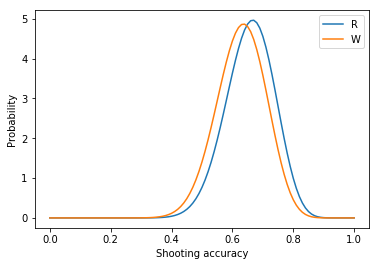

In [14]:
X = np.linspace(0, 1, 101)
plt.plot(X, scipy.stats.beta(**prm_R).pdf(X), label='R')
plt.plot(X, scipy.stats.beta(**prm_W).pdf(X), label='W')
plt.xlabel('Shooting accuracy')
plt.ylabel('Probability')
plt.legend()
plt.show()

To compute the probability that Rhode actually has a higher value of `p`, there are two options:

1. Sampling: we could draw random samples from the posterior distributions and compare them.

2. Enumeration: we could enumerate all possible pairs of values and add up the "probability of superiority".

I'll start with sampling.  The Beta object provides a method that draws a random value from a Beta distribution:

`Beta` also provides `Sample`, which returns a NumPy array, so we an perform the comparisons using array operations:

In [15]:
iters = 1000
x_R = scipy.stats.beta(**prm_R).rvs(iters)
x_W = scipy.stats.beta(**prm_W).rvs(iters)
count = sum(x_R > x_W)

count / iters

0.635

The other option is to make `Pmf` objects that approximate the Beta distributions, and enumerate pairs of values:

In [16]:
def prob_cmp(pmf1, pmf2, cmpfunc):
    """"""
    p = 0
    for acc1, prob1 in pmf1.items():
        for acc2, prob2 in pmf2.items():
            if cmpfunc(acc1, acc2):
                p += prob1 * prob2
    return p

X = np.linspace(0, 1, 1001)
pmf_R = mtb.PMF(hypos=X, priors=scipy.stats.beta(**prm_R).pdf(X))
pmf_W = mtb.PMF(hypos=X, priors=scipy.stats.beta(**prm_W).pdf(X))
print('P(R > W) = %.5lf' % prob_cmp(pmf_R, pmf_W, lambda a, b: a > b))
print('P(R < W) = %.5lf' % prob_cmp(pmf_R, pmf_W, lambda a, b: a < b))
print('P(R = W) = %.5lf' % prob_cmp(pmf_R, pmf_W, lambda a, b: a == b))

P(R > W) = 0.59829
P(R < W) = 0.39831
P(R = W) = 0.00340


**Exercise:** Run this analysis again with a different prior and see how much effect it has on the results.

In [17]:
# Let's say that Rhode and Wei play a longer game - 250 shots instead of 25 -
# and Rhode edges Wei by one shot. If we make this result the prior, then
# the Rhodes probability goes down and Wei's goes up.
X = np.linspace(0, 1, 1001)
pmf_R = mtb.PMF(hypos=X, priors=scipy.stats.beta(151, 99).pdf(X))
pmf_W = mtb.PMF(hypos=X, priors=scipy.stats.beta(150, 100).pdf(X))
print('P(R > W) = %.5lf' % prob_cmp(pmf_R, pmf_W, lambda a, b: a > b))
print('P(R < W) = %.5lf' % prob_cmp(pmf_R, pmf_W, lambda a, b: a < b))
print('P(R = W) = %.5lf' % prob_cmp(pmf_R, pmf_W, lambda a, b: a == b))

P(R > W) = 0.53193
P(R < W) = 0.45899
P(R = W) = 0.00908


## Mixture of Dice

Walking through the mixture of dice example in 5.6.

The most likely rolls from the mixture of dice are the low values, because they are available on all dice.

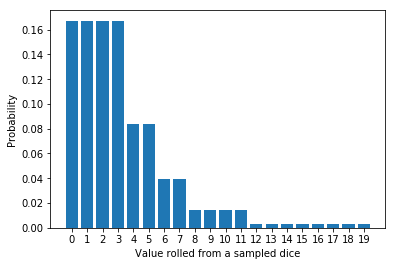

In [18]:
dmix = mtb.PMF.from_mixture([
    (mtb.PMF(range(4)), 5),  # 5x 4-sided
    (mtb.PMF(range(6)), 4),  # 4x 6-sided
    (mtb.PMF(range(8)), 3),  # 3x 8-sided
    (mtb.PMF(range(12)), 2), # 2x 12-sided
    (mtb.PMF(range(20)), 1)  # 1x 20-sided
])

plt.bar(dmix.hypos, dmix.probs)
plt.xticks(range(len(dmix)), dmix.hypos)
plt.ylabel('Probability')
plt.xlabel('Value rolled from a sampled dice')
plt.show()

## Simulation

To make predictions about a rematch, we have two options again:

1. Sampling.  For each simulated match, we draw a random value of `x` for each contestant, then simulate 25 shots and count hits.

2. Computing a mixture.  If we knew `x` exactly, the distribution of hits, `k`, would be binomial.  Since we don't know `x`, the distribution of `k` is a mixture of binomials with different values of `x`.

I'll do it by sampling first.

Now we can simulate 1000 rematches and count wins and losses.

In [19]:
iters = 1000
wins = 0
losses = 0

# Prepare a distribution of accuracies for each player.
rv_R = scipy.stats.beta(**prm_R)
rv_W = scipy.stats.beta(**prm_W)

for _ in range(iters):
    
    # Get each player's accuracy for this game.
    acc_R = rv_R.rvs()
    acc_W = rv_W.rvs()
    
    # Each player takes 25 shots (hit = 1, miss = 0).    
    # Sum up the shots to get number of hits.
    hits_R = np.random.binomial(1, acc_R, 25).sum()
    hits_W = np.random.binomial(1, acc_W, 25).sum()
            
    wins += hits_R > hits_W
    losses += hits_R < hits_W
        
wins / iters, losses / iters

(0.531, 0.383)

Or, realizing that the distribution of `k` is binomial, we can simplify the code using NumPy:

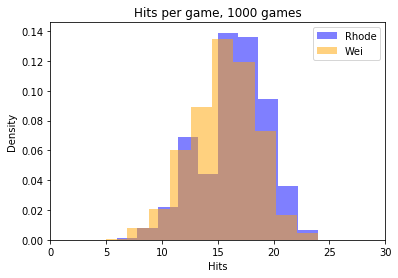

In [20]:
hits_R = np.random.binomial(25, rv_R.rvs(iters))
plt.hist(hits_R, label='Rhode', color='blue', alpha=0.5, density=True)

hits_W = np.random.binomial(25, rv_W.rvs(iters))
plt.hist(hits_W, label='Wei', color='orange', alpha=0.5, density=True)

plt.title('Hits per game, %d games' % iters)
plt.xlabel('Hits')
plt.ylabel('Density')
plt.xlim(0, 30)
plt.legend()
plt.show()

In [21]:
np.mean(hits_R < hits_W)

0.381

Alternatively, we can make a mixture that represents the distribution of `k`, taking into account our uncertainty about `x`:

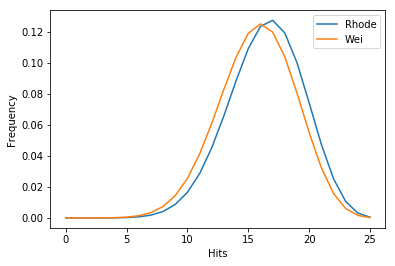

P(R > W) = 0.52023
P(R < W) = 0.39053
P(R = W) = 0.08924


In [22]:
def get_binomial_mixture(pmf, n_flips=25):
    """Function explained based on the Olympic shooting example:
    
    
    Given a PMF of a shooter's accuracies:
    1. compute a binomial PMF for each of the accuracies that defines
    the probability of making each number of shots <= n_shots.
    2. combine the binomial PMFs into a single mixture of binomials.
    
    Using the "Binomial" here is a little confusing at first, because each binomial
    PMF defines a probability for hitting each of (0, 1, ... n_shots) shots.
    """
    
    # Instantiate a binomial PMF for each possible accuracy in the acc_pmf.
    # Each PMF defines the probability of making each possible number of shots
    # given an accuracy value from the acc_pmf.
    hypos = np.arange(n_flips + 1)
    binomial_pmfs = [
        (mtb.PMF(hypos, scipy.stats.binom(n=n_flips, p=val).pmf(hypos)), prob)
        for val, prob in pmf.items()
    ]
    
    # Combine the binomial PMFs as a mixture.
    return mtb.PMF.from_mixture(binomial_pmfs)

hypos = np.linspace(0, 1, 27)
acc_pmf_R = mtb.PMF(hypos, scipy.stats.beta(**prm_R).pdf(hypos))
acc_pmf_W = mtb.PMF(hypos, scipy.stats.beta(**prm_W).pdf(hypos))

# These will get used many times below.
mix_pmf_R = get_binomial_mixture(acc_pmf_R)
mix_pmf_W = get_binomial_mixture(acc_pmf_W)

plt.plot(mix_pmf_R.hypos, mix_pmf_R.probs, label='Rhode')
plt.plot(mix_pmf_W.hypos, mix_pmf_W.probs, label='Wei')
plt.xlabel('Hits')
plt.ylabel('Frequency')
plt.legend()
plt.show()

print('P(R > W) = %.5lf' % prob_cmp(mix_pmf_R, mix_pmf_W, lambda a, b: a > b))
print('P(R < W) = %.5lf' % prob_cmp(mix_pmf_R, mix_pmf_W, lambda a, b: a < b))
print('P(R = W) = %.5lf' % prob_cmp(mix_pmf_R, mix_pmf_W, lambda a, b: a == b))

**Exercise:** Run this analysis again with a different prior and see how much effect it has on the results.

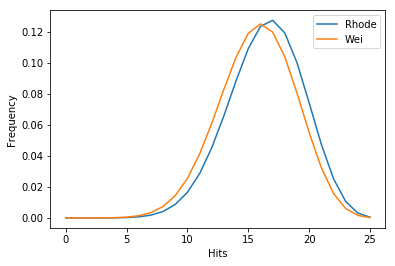

P(R > W) = 0.52023
P(R < W) = 0.39053
P(R = W) = 0.08924


In [23]:
# Similar to the previous "try another prior" exercises, use a prior
# consisting of 250 shots instead of 25. Otherwise code is same as above.
# Again, using a more informative prior causes the two distributions
# to be much closer with a lesser probability of Rhode winning.

plt.plot(mix_pmf_R.hypos, mix_pmf_R.probs, label='Rhode')
plt.plot(mix_pmf_W.hypos, mix_pmf_W.probs, label='Wei')
plt.xlabel('Hits')
plt.ylabel('Frequency')
plt.legend()
plt.show()

print('P(R > W) = %.5lf' % prob_cmp(mix_pmf_R, mix_pmf_W, lambda a, b: a > b))
print('P(R < W) = %.5lf' % prob_cmp(mix_pmf_R, mix_pmf_W, lambda a, b: a < b))
print('P(R = W) = %.5lf' % prob_cmp(mix_pmf_R, mix_pmf_W, lambda a, b: a == b))

## Distributions of sums and differences

Suppose we want to know the total number of targets the two contestants will hit in a rematch.  There are two ways we might compute the distribution of this sum:

1. Sampling: We can draw samples from the distributions and add them up.

2. Enumeration: We can enumerate all possible pairs of values.

I'll start with sampling:

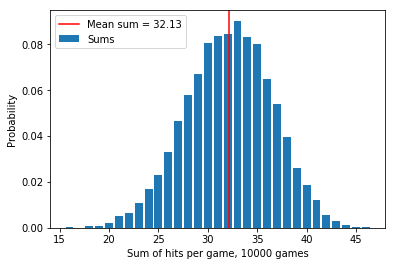

In [24]:
n_games = 10000
n_shots = 25

acc_rv_R = scipy.stats.beta(**prm_R)
acc_rv_W = scipy.stats.beta(**prm_W)

sums = []

for _ in range(n_games):
    acc_R = acc_rv_R.rvs()
    acc_W = acc_rv_W.rvs()
    sum_R = np.random.binomial(n_shots, acc_R)
    sum_W = np.random.binomial(n_shots, acc_W)
    sums.append(sum_R + sum_W)
    
sums_pmf = mtb.PMF.from_observations(sums)

plt.bar(sums_pmf.hypos, sums_pmf.probs, label='Sums')
plt.axvline(sums_pmf.expectation(), label='Mean sum = %.2lf' % sums_pmf.expectation(), color='red')
plt.xlabel('Sum of hits per game, %d games' % (n_games))
plt.ylabel('Probability')
plt.legend()
plt.show()

Alternatively, we could compute the distribution of the sum by enumeration:

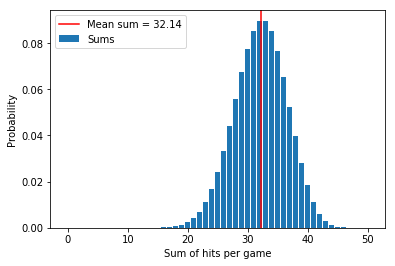

In [25]:
def add_pmfs(pmf1, pmf2):
    """Create a new PMF by adding the values of the two given PMFs and
    multiplying each pair of values' probabilities to get the probability
    of that sum."""
    pmf = mtb.PMF(hypos=range(max(pmf1.hypos) + max(pmf2.hypos) + 1))
    pmf *= 0
    for v1, p1 in pmf1.items():
        for v2, p2 in pmf2.items():
            pmf[v1 + v2] += p1 * p2
    return pmf

mix_pmf_sum = add_pmfs(mix_pmf_R, mix_pmf_W)

plt.bar(mix_pmf_sum.hypos, mix_pmf_sum.probs, label='Sums')
plt.axvline(mix_pmf_sum.expectation(), color='red', 
            label='Mean sum = %.2lf' % mix_pmf_sum.expectation())
plt.xlabel('Sum of hits per game')
plt.ylabel('Probability')
plt.legend()
plt.show()

**My Exercise:** implement the `+` operator to perform the above addition for two PMFs.

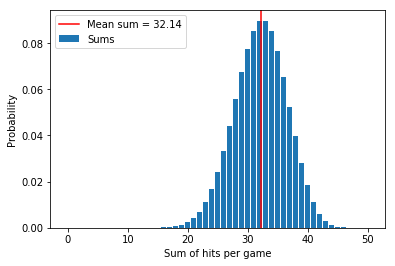

In [26]:
mix_pmf_sum = mix_pmf_R + mix_pmf_W

plt.bar(mix_pmf_sum.hypos, mix_pmf_sum.probs, label='Sums')
plt.axvline(mix_pmf_sum.expectation(), color='red', 
            label='Mean sum = %.2lf' % mix_pmf_sum.expectation())
plt.xlabel('Sum of hits per game')
plt.ylabel('Probability')
plt.legend()
plt.show()

**Exercise:**  The Pmf class also provides the `-` operator, which computes the distribution of the difference in values from two distributions.  Use the distributions from the previous section to compute the distribution of the differential between Rhode and Wei in a rematch.  On average, how many clays should we expect Rhode to win by?  What is the probability that Rhode wins by 10 or more?

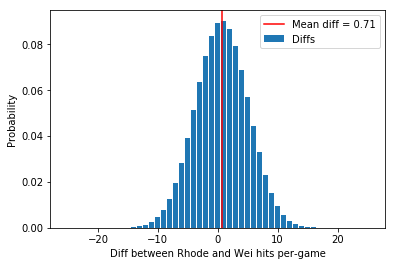

P(R - W >= 10) = 1 - P(R - W <= 9) = 0.0214


In [27]:
mix_pmf_diff = mix_pmf_R - mix_pmf_W

plt.bar(mix_pmf_diff.hypos, mix_pmf_diff.probs, label='Diffs')
plt.axvline(mix_pmf_diff.expectation(), color='red', 
            label='Mean diff = %.2lf' % mix_pmf_diff.expectation())
plt.xlabel('Diff between Rhode and Wei hits per-game')
plt.ylabel('Probability')
plt.legend()
plt.show()

mix_cdf_diff = mtb.CDF.from_pmf(mix_pmf_diff)
print('P(R - W >= 10) = 1 - P(R - W <= 9) = %.4lf' % (1 - mix_cdf_diff[9]))

## Distribution of maximum

Suppose Kim Rhode continues to compete in six more Olympics.  What should we expect her best result to be?

Once again, there are two ways we can compute the distribution of the maximum:

1. Sampling.

2. Analysis of the CDF.

Here's a simple version by sampling:

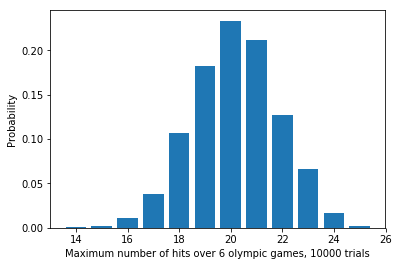

In [28]:
n_iters = 10000
n_olympics = 6

best_results = mix_pmf_R.sample((n_iters, n_olympics)).max(axis=1)
pmf = mtb.PMF.from_observations(best_results)
plt.bar(pmf.hypos, pmf.probs)
plt.xlabel('Maximum number of hits over %d olympic games, %d trials' % (n_olympics, n_iters))
plt.ylabel('Probability')
plt.show()

Or we can figure it out analytically.  If the maximum is less-than-or-equal-to some value `k`, all 6 random selections must be less-than-or-equal-to `k`, so: 

$ CDF_{max}(x) = CDF(x)^6 $

***How does this work?***

- The CDF maps an observable value to the probability of observing that value or a value less than it.
- If you want to know the probability of observing a specific value or a value less than it over `k` observations, you have to multiply these original probabilities `k` times, hence the exponentiation. 


`Pmf` provides a method that computes and returns this `Cdf`, so we can compute the distribution of the maximum like this:

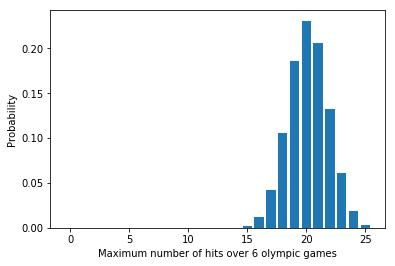

In [29]:
max_pmf_R = (mix_pmf_R.to_cdf() ** n_olympics).to_pmf()
plt.bar(max_pmf_R.hypos, max_pmf_R.probs)
plt.xlabel('Maximum number of hits over %d olympic games' % n_olympics)
plt.ylabel('Probability')
plt.show()

**Exercise:**  Here's how Pmf.Max works:

    def Max(self, k):
        """Computes the CDF of the maximum of k selections from this dist.

        k: int

        returns: new Cdf
        """
        cdf = self.MakeCdf()
        cdf.ps **= k
        return cdf

Write a function that takes a Pmf and an integer `n` and returns a Pmf that represents the distribution of the minimum of `k` values drawn from the given Pmf.  Use your function to compute the distribution of the minimum score Kim Rhode would be expected to shoot in six competitions.

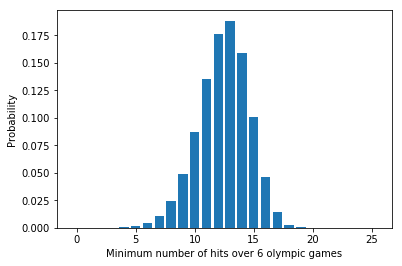

In [30]:
# This one is a little tough to follow, but the comments should help.

x = mix_pmf_R          # start with P(x)
x = mix_pmf_R.to_cdf() # convert to P(X <= x)
x = x.to_ccdf()        # convert to P(X > x)
x = x ** n_olympics    # convert to P(X > x over k observations)
x = x.to_ccdf()        # convert to P(X <= x)
min_pmf_R = x.to_pmf() # convert to P(x)

plt.bar(min_pmf_R.hypos, min_pmf_R.probs)
plt.xlabel('Minimum number of hits over %d olympic games' % n_olympics)
plt.ylabel('Probability')
plt.show()

## Exercises

**Exercise:**  Suppose you are having a dinner party with 10 guests and 4 of them are allergic to cats.  Because you have cats, you expect 50% of the allergic guests to sneeze during dinner.  At the same time, you expect 10% of the non-allergic guests to sneeze.  What is the distribution of the total number of guests who sneeze?

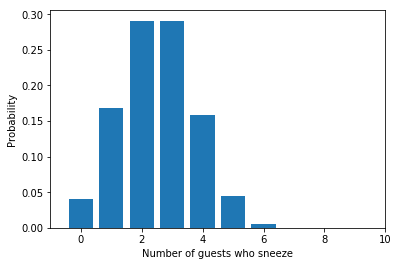

In [31]:
# Solved computationally (sampling).
n_guests = 10
n_allerg = 4

guests = [mtb.PMF([1, 0], [0.1, 0.9]) for _ in range(n_guests - n_allerg)]
guests += [mtb.PMF([1, 0], [0.5, 0.5]) for _ in range(n_allerg)]

n_iters = 1000
sums = []

for _ in range(n_iters):
    sums.append(0)
    for guest in guests:
        sums[-1] += guest.sample()[0]
        
sums_pmf = mtb.PMF.from_observations(sums)
plt.bar(sums_pmf.hypos, sums_pmf.probs)
plt.xlabel('Number of guests who sneeze')
plt.ylabel('Probability')
plt.xlim(-1, 10)
plt.show()

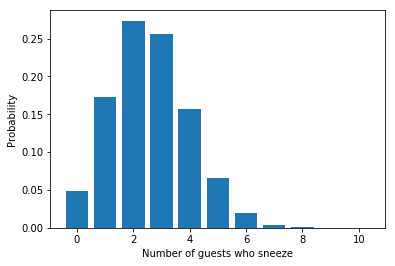

In [32]:
# Solved analytically.
# Compute a mixture from the two types of guests (allergic, non-allergic),
# weighted by the number of each type.
# Then compute the PMF for each of the possible numbers of guests that will
# sneeze: [0, 1, ... 10].

mix_pmf = mtb.PMF.from_mixture([
    (mtb.PMF(['sneeze', 'no-sneeze'], [0.1, 0.9]), 6),
    (mtb.PMF(['sneeze', 'no-sneeze'], [0.5, 0.5]), 4)
])

sums = range(n_guests + 1)
probs = scipy.stats.binom(n=10, p=mix_pmf['sneeze']).pmf(sums)
sum_pmf = mtb.PMF(sums, probs)
plt.bar(sum_pmf.hypos, sum_pmf.probs)
plt.xlabel('Number of guests who sneeze')
plt.ylabel('Probability')
plt.show()

**Exercise** [This study from 2015](http://onlinelibrary.wiley.com/doi/10.1111/apt.13372/full) showed that many subjects diagnosed with non-celiac gluten sensitivity (NCGS) were not able to distinguish gluten flour from non-gluten flour in a blind challenge.

Here is a description of the study:

>"We studied 35 non-CD subjects (31 females) that were on a gluten-free diet (GFD), in a double-blind challenge study. Participants were randomised to receive either gluten-containing ﬂour or gluten-free ﬂour for 10 days, followed by a 2-week washout period and were then crossed over. The main outcome measure was their ability to identify which ﬂour contained gluten.
>"The gluten-containing ﬂour was correctly identiﬁed by 12 participants (34%)..."
Since 12 out of 35 participants were able to identify the gluten flour, the authors conclude "Double-blind gluten challenge induces symptom recurrence in just one-third of patients fulﬁlling the clinical diagnostic criteria for non-coeliac gluten sensitivity."

This conclusion seems odd to me, because if none of the patients were sensitive to gluten, we would expect some of them to identify the gluten flour by chance.  So the results are consistent with the hypothesis that none of the subjects are actually gluten sensitive.

We can use a Bayesian approach to interpret the results more precisely.  But first we have to make some modeling decisions.

1. Of the 35 subjects, 12 identified the gluten flour based on resumption of symptoms while they were eating it.  Another 17 subjects wrongly identified the gluten-free flour based on their symptoms, and 6 subjects were unable to distinguish.  So each subject gave one of three responses.  To keep things simple I follow the authors of the study and lump together the second two groups; that is, I consider two groups: those who identified the gluten flour and those who did not.

2. I assume (1) people who are actually gluten sensitive have a 95% chance of correctly identifying gluten flour under the challenge conditions, and (2) subjects who are not gluten sensitive have only a 40% chance of identifying the gluten flour by chance (and a 60% chance of either choosing the other flour or failing to distinguish).

Using this model, estimate the number of study participants who are sensitive to gluten.  What is the most likely number?  What is the 95% credible interval?

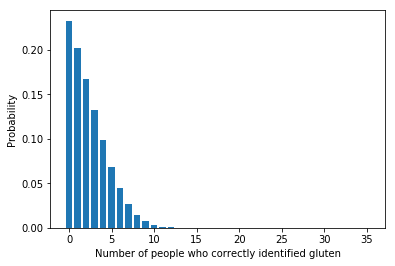

In [33]:
n_people_total = 35
n_people_ident = 12
sensitivity_pmf = mtb.PMF(range(n_people_total + 1))

# Update the PMF for each possible number of sensitive people.
for N in sensitivity_pmf.hypos:
    
    # PMF defining the probability of each number of people up to N
    # correctly identifying the gluten given a 95% prior of being correct.
    sens_hypos = range(N + 1)
    sens_probs = scipy.stats.binom(max(sens_hypos), p=0.95).pmf(sens_hypos)
    sens_pmf = mtb.PMF(sens_hypos, sens_probs)
    
    # PMF definign the probability of each number of people up to 35 - N
    # correctly identifying the gluten given a 40% prior of being correct.
    norm_hypos = range(n_people_total - N + 1)
    norm_probs = scipy.stats.binom(max(norm_hypos), p=0.4).pmf(norm_hypos)
    norm_pmf = mtb.PMF(norm_hypos, norm_probs)
    
    # Add the two PMFs to get a PMF defining the sum of people who correctly
    # identify the gluten.
    sum_pmf = sens_pmf + norm_pmf
    
    # Lookup the probability of a sum of 12 people correctly identifying the gluten.
    likelihood = sum_pmf[n_people_ident]
    sensitivity_pmf[N] *= likelihood
    
sensitivity_pmf.normalize()


plt.bar(sensitivity_pmf.hypos, sensitivity_pmf.probs)
plt.xlabel('Number of people who correctly identified gluten')
plt.ylabel('Probability')
plt.show()

In [34]:
'Done'

'Done'

**Exercise** Coming soon: the space invaders problem.

In [35]:
# Solution goes here

In [36]:
# Solution goes here

In [37]:
# Solution goes here

In [38]:
# Solution goes here

In [39]:
# Solution goes here

In [40]:
# Solution goes here

In [41]:
# Solution goes here

In [42]:
# Solution goes here